# Ordinary and Simple Kriging - tutorial

## Table of Contents:

1. Read point data,
2. Set semivariogram model,
3. Set Ordinary Kriging and Simple Kriging models,
4. Predict values at unknown locations.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2022-08-20 | Updated to the version 0.3.0 | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class & error variance estimated in a correct way | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function | @SimonMolinsky |
| 2021-12-11 | Behavior of `prepare_kriging_data()` function has benn changed | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-04-03 | Simple Kriging `global_mean` parameter update. | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated point data source. | @SimonMolinsky |

## Introduction

In this tutorial we will learn how to perform the spatial interpolation with Ordinary and Simple Kriging. We will compare different number of ranges and test outcomes of processing with the root mean squared error.

Ordinary and Simple Kriging are the simplest form of Kriging, but they're still very powerful techniques.

We use DEM data which is stored in a file `samples/point_data/txt/pl_dem_epsg2180.txt`.

## Import packages

In [1]:
from typing import List

import numpy as np

from pyinterpolate.io import read_txt
from pyinterpolate.variogram import build_experimental_variogram, build_theoretical_variogram
from pyinterpolate.kriging.point_kriging import kriging

## 1) Read point data

In [2]:
dem = read_txt('samples/point_data/txt/pl_dem_epsg2180.txt')
dem[: 3]

array([[2.37685325e+05, 5.45416708e+05, 5.12545509e+01],
       [2.37674140e+05, 5.45209671e+05, 4.89582825e+01],
       [2.37449255e+05, 5.41045935e+05, 1.68178635e+01]])

At the beginning we remove 70 % of our points from the dataset and we will left them as an test set to estimate how good are our models.

In [3]:
def create_train_test(dataset: np.ndarray, frac=0.7):
    """
    Function divides base dataset into a training and a test set.

    Parameters
    ----------
    dataset : np.ndarray

    frac : float, default = 0.2
    
    Returns
    -------
    training_set, test_set : List[np.ndarray]
    """

    np.random.seed(101)  # To ensure that we will get the same results every time

    removed_idx = np.random.randint(0, len(dataset)-1, size=int(frac * len(dataset)))
    testset = dataset[removed_idx]
    trainingset = np.delete(dataset, removed_idx, 0)
    return trainingset, testset


train_set, test_set = create_train_test(dem)

We have removed subset of points from a dataset to be sure that Kriging is working. In this scenario 70% of available points are removed, but in a real-world cases you will probably have even less points to perform estimations, down to the 1% of known values.

Function `create_train_test()` divides our dataset into two subsets:
- **training set** used for semivariogram model derivation,
- **test set** used for the model error calculation.

Points for each set are chosen randomly to avoid bias related to the geographical location. Let's imagine that we have a sorted list of Digital Elevation Model points. The western part of our measurements covers a mountain and the eastern part is a plain. When we use the western part for a modeling and the eastern part for tests we are going directly into a catastrophe! That's why it's better to perform multiple random sampling and test multiple realizations from our data. We will prepare only one realization with a fixed random seed, but you should be aware that in the real-world analysis we must prepare more realizations (e.g.: set multiple random seeds).

## 2) Set Semivariogram model

In this step, we are going to create experimental and theoretical semivariograms. More about the experimental semivariogram estimation is [here]() or [here]().

In [4]:
# Create experimental semivariogram

# Prepare experimental semivariogram

step_radius = 500  # meters
max_range = 10000  # meters

exp_semivar = build_experimental_variogram(input_array=train_set, step_size=step_radius, max_range=max_range)

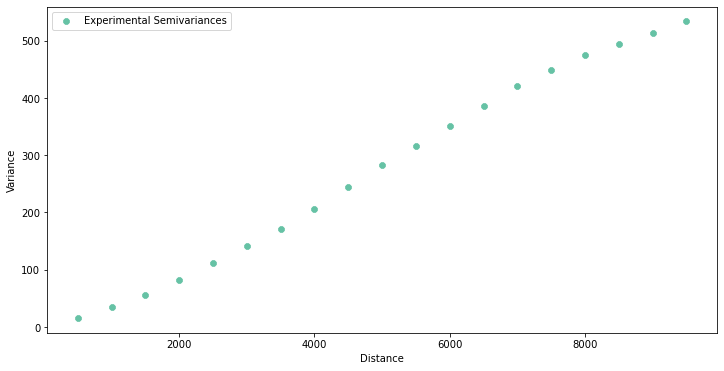

In [5]:
# Plot experimental semivariogram

exp_semivar.plot()

In [6]:
# Fit data into a theoretical model

semivar = build_theoretical_variogram(experimental_variogram=exp_semivar, model_type='linear', sill=exp_semivar.variance, rang=10000)

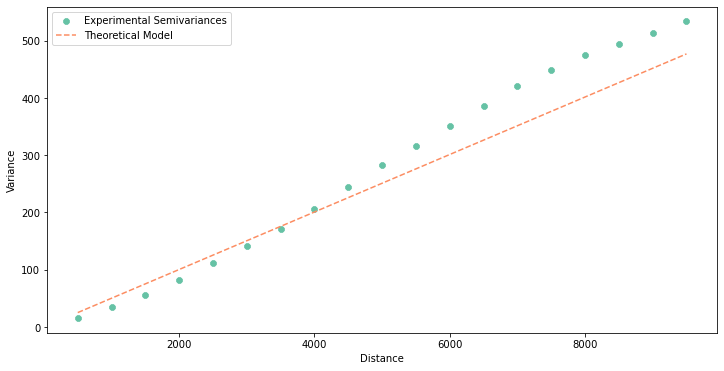

In [7]:
semivar.plot()

In [8]:
print(semivar)

* Selected model: Linear model
* Nugget: 0.0
* Sill: 502.1478552791644
* Range: 10000
* Mean Bias: 27.316066997374072
* Mean RMSE: 44.33535794872789
* Error-lag weighting method: None

+--------+--------------------+--------------------+---------------------+
|  lag   |    theoretical     |    experimental    |     bias (y-y')     |
+--------+--------------------+--------------------+---------------------+
| 500.0  | 25.10739276395822  | 15.685422829102698 |  -9.421969934855522 |
| 1000.0 | 50.21478552791644  | 35.23923933757287  | -14.975546190343572 |
| 1500.0 | 75.32217829187465  | 56.351669380560246 | -18.970508911314404 |
| 2000.0 | 100.42957105583288 | 82.39521047099969  | -18.034360584833195 |
| 2500.0 | 125.5369638197911  | 111.26318241073449 |  -14.27378140905661 |
| 3000.0 | 150.6443565837493  | 142.15040290428337 |  -8.493953679465932 |
| 3500.0 | 175.75174934770752 | 171.76539947943704 |  -3.98634986827048  |
| 4000.0 | 200.85914211166576 | 206.84908400021737 |  5.989941888

## 3) Set Ordinary Kriging and Simple Kriging models

This is the most important step of our tutorial. We've set our semivariogram model and now we are able to perform prediction of an unknown values. In a first run, we will "predict" known, arbitrary point. It is a test of Kriging: it is **unbiased linear estimator**, thus it should return **exact** value from a known point. In the second step, we will try to guess values at unknown locations and calculate the **R**oot **M**ean **S**quared **E**rror (RMSE) of interpolated values.

For both kriging types we can use the same `kriging()` function. It takes those arguments:

- `observations`: array with known points,
- `theoretical_model`: fitted `TheoreticalVariogram` model,
- `points`: points to interpolate values,
- `how`: `ok` - ordinary kriging, `sk` - simple kriging,
- `neighbors_range`: `None` or `float`, the maximum distance where we search for point neighbors. If `None` given then range is selected from the `theoretical_model` `rang` attribute.
- `no_neighbors`: `int`, number of neighbors to estimate unknown value.
- `use_all_neighbors_in_range`: `bool`, default is `False`. `True`: if number of neighbors within the `neighbors_range` is greater than the `number_of_neighbors` then take all of them for modeling.
- `sk_mean`: `None` or `float`, the mean value of a process over a study area. Should be know before processing. That's why Simple Kriging has limited number of applications. You must have multiple samples and well-known area to know this parameter.
- `allow_approx_solutions`: Allows the approximation of kriging weights based on the OLS algorithm. Not recommended to set to True if you don't know what you are doing! By default, it is set to `False`,
- `number_of_workers`: if we pass more than 10k points to interpolate, it is recommended to set this parameter to the number of your CPU workers (or -1) - it will speed up calculations.

We use only the first four parameters, and `sk_mean` when we perform Simple Kriging. Let's start! The first step is an interpolation of value known by our model.

In [9]:
# Select one known value

known_value = train_set[10]
known_value

array([2.37852392e+05, 5.47022672e+05, 7.61861649e+01])

In [10]:
# Predict with Ordinary Kriging

ok_interpolation = kriging(train_set, semivar, [known_value[:-1]])
ok_interpolation

100%|██████████| 1/1 [00:00<00:00, 666.40it/s]


array([[7.61861649e+01, 0.00000000e+00, 2.37852392e+05, 5.47022672e+05]])

As we see, the first value is our prediction: it is exactly the same as input in training set! So far, algoritm works well. The second value is prediction variance error, it is equal to zero - we are sure that it is the exact value.

Simple Kriging is slightly different than the Ordinary Kriging and we must set the process mean to retrive a valid results. It is rarely the case, that's why Ordinary Kriging is the first choice for many applications. We know global mean beacuse we have whole dataset but in the real-world scenario we cannot divide set into training and test sets and then get mean from the whole dataset - it is a information leak from the test set into a model!

In [11]:
sk_interpolation = kriging(train_set, semivar, [known_value[:-1]], how='sk', sk_mean=np.mean(dem))
sk_interpolation

100%|██████████| 1/1 [00:00<00:00, 224.21it/s]


array([[7.61861649e+01, 0.00000000e+00, 2.37852392e+05, 5.47022672e+05]])

The Simple Kriging algorithm returns the same output as the Ordinary Kriging: `[prediction, error variance, pt x, pt y]`. And as with Ordinary Kriging, Simple Kriging has returned the same value as real value that was fed to the algorithm.

## 4) Predict values at unknown locations

Kriging to retrieve known points values is pointless, it is a great tool for testing algorithm but nothing more. Here we are going to do what Kriging is designed for. We will interpolate values at unknown locations. Additionally, we will control `no_neighbors` parameter to check, how it influences predictions.

In the first move, we will create a simple function to test our kriging results and to calculate RMSE from those.

In [16]:
def test_kriging(train_set, variogram_model, ktype, test_values, number_of_neighbors, sk_mean=None):
    predictions = kriging(observations=train_set,
                          theoretical_model=variogram_model,
                          points=test_values[:, :-1],
                          how=ktype,
                          no_neighbors=number_of_neighbors,
                          number_of_workers=1,
                          sk_mean=sk_mean)
    mse = np.mean((predictions[:, 0] - test_values[:, -1])**2)
    rmse = np.sqrt(mse)
    return rmse

In [19]:
# Number of neighbors

no_of_n = [4, 8, 16, 32, 64, 128, 256]
print('Ordinary Kriging: tests')
print('')

for nn in no_of_n:
    print('Number of neighbors:', nn)
    rmse_pred = test_kriging(train_set=train_set, variogram_model=semivar, ktype='ok', test_values=test_set, number_of_neighbors=nn)
    print('RMSE:', rmse_pred)
    print('')

Ordinary Kriging: tests

Number of neighbors: 4


100%|██████████| 4825/4825 [00:01<00:00, 2626.03it/s]


RMSE: 2.8188672843881393

Number of neighbors: 8


100%|██████████| 4825/4825 [00:01<00:00, 2681.74it/s]


RMSE: 2.686005773876241

Number of neighbors: 16


100%|██████████| 4825/4825 [00:01<00:00, 2522.57it/s]


RMSE: 2.6430398276118194

Number of neighbors: 32


100%|██████████| 4825/4825 [00:14<00:00, 323.19it/s] 


RMSE: 2.6331569086257285

Number of neighbors: 64


100%|██████████| 4825/4825 [00:08<00:00, 560.62it/s]


RMSE: 2.632338377459987

Number of neighbors: 128


100%|██████████| 4825/4825 [00:13<00:00, 357.67it/s]


RMSE: 2.6311211699475567

Number of neighbors: 256


100%|██████████| 4825/4825 [00:52<00:00, 91.73it/s] 

RMSE: 2.6309421059722506



In [20]:
print('Simple Kriging: tests')
print('')

sk_mean = np.mean(dem[:, -1])

for nn in no_of_n:
    print('Number of neighbors:', nn)
    rmse_pred = test_kriging(train_set=train_set, variogram_model=semivar, ktype='sk', test_values=test_set, number_of_neighbors=nn, sk_mean=sk_mean)
    print('RMSE:', rmse_pred)
    print('')

Simple Kriging: tests

Number of neighbors: 4


100%|██████████| 4825/4825 [00:01<00:00, 3021.53it/s]


RMSE: 5.32695312780116

Number of neighbors: 8


100%|██████████| 4825/4825 [00:01<00:00, 2969.61it/s]


RMSE: 3.1291216204454035

Number of neighbors: 16


100%|██████████| 4825/4825 [00:01<00:00, 2963.65it/s]


RMSE: 2.728023100559632

Number of neighbors: 32


100%|██████████| 4825/4825 [00:04<00:00, 969.05it/s] 


RMSE: 2.6447451848933268

Number of neighbors: 64


100%|██████████| 4825/4825 [00:06<00:00, 786.86it/s] 


RMSE: 2.6333680288613763

Number of neighbors: 128


100%|██████████| 4825/4825 [00:05<00:00, 830.38it/s]


RMSE: 2.6308138101222833

Number of neighbors: 256


100%|██████████| 4825/4825 [00:17<00:00, 282.49it/s]

RMSE: 2.6307300408949037



Usually Simple Kriging will give us worse results than Ordinary Kriging because we do not know process mean. Only if we know process mean, we can use Simple Kriging with a large number of neighbors. We see, that results of Simple Kriging are better when we pass more values into it. This shouldn't be a shock, Simple Kriging *knows* global mean and it utilizes this information when building a Kriging system.

On the other hand, Ordinary Kriging is a swiss knife in our geostatistical toolbox. It works well even if we don't know process mean. It should be our first-choice technique.

Let's look into processing times with a growing numbers of neighbors. We can theoretically take more and more neighbors, but is it worth it?

- **Small dataset**: with small datasets (up to 1000 points) we may consider using large number of neighbors, it shouldn't be a problem for a processing time.
- **Large dataset**: more than 5000 points? Then we must take into account two scenarios:
1. A single report or only one-time analysis - then use as much neighbors as it is possible (within range);
2. Near-real time and frequent analyses / system - then use smaller number of neighbors, between 8 - 128.

---